## Information Extraction Example - Circularity in Machine Learning Prediction


In this notebook the circularity test from chapter 2.4.3 of "Validity, Reliability, and Significance: Empirical Methods for NLP and Data Science
" (Riezler&Hagmann, 2021), for the IR example is executed and visualized step-by-step, just as circularitytest would handle it internally.

**Please note**: Unlike specified in the book and the accompanying code, I had trouble with the convergence of some of the GAMs when using a binomial distribution and logit link. However, unlike in mgcv, the circularity test (convergence of GAMs) worked perfectly when using a normal distribution and identity link. Therefore the distribution and link in this example are different from those in the book. 


**Definition Circularity Test (2.6)**: \
Given a dataset of feature-label relations $D = \{(x^{n}, y^{n})\}^{N}_{n=1}$ where $x^{n} = (x_1, x_2, . . . , x_p)$ is a $p$-dimensional feature vector, let $C \subseteq P(\{1, . . . , p\})$ indicate the set of candidate circular features in dataset $D$, and let $M := \{\mu_c : c \in C\}$ be the set of models obtained by fitting a GAM based on feature set $c$ to the data $D$. A set of circular features $c∗$ is detected by applying the following two-step test:
1. $c∗ = argmax_{c\subseteq C} D^2(\mu_c)$ where $D^2
(\mu_{c∗} )$ is close to 1, and in case
the maximizer is not unique, the maximizer is chosen whose
associated GAM $\mu_{c∗}$ has the smallest degrees of freedom.
2. The feature shapes of any other features added to the GAM
$\mu_{c∗}$ are nullified in the model $\mu\{1,...,p\}$ that is based on the full
feature set.

In [1]:
# Imports
from circularitytest.gam import construct_powerset, construct_gam_term, build_gam, check_nullification, score
from circularitytest.utils import load_r_data, preprocess_replace_data
from circularitytest.plot import plot_gam_terms
from tqdm import tqdm
import pandas as pd
pd.set_option('display.max_colwidth', 100)


Features, Target for knowledge distillation from teacher trained for cross-lingual patent retrieval

In [2]:
# Feature definitions
features = sorted(["cited_inventor" , "cited_examiner", "cited_family", "score_neural", "score_tfIdf"])
target = "score_bief"


Construct all possible feature sets $c$ from the features 

In [3]:
# Obtain feature combinations
feature_combinations = construct_powerset(features)
feature_combinations

[['cited_examiner'],
 ['cited_family'],
 ['cited_inventor'],
 ['score_neural'],
 ['score_tfIdf'],
 ['cited_examiner', 'cited_family'],
 ['cited_examiner', 'cited_inventor'],
 ['cited_examiner', 'score_neural'],
 ['cited_examiner', 'score_tfIdf'],
 ['cited_family', 'cited_inventor'],
 ['cited_family', 'score_neural'],
 ['cited_family', 'score_tfIdf'],
 ['cited_inventor', 'score_neural'],
 ['cited_inventor', 'score_tfIdf'],
 ['score_neural', 'score_tfIdf'],
 ['cited_examiner', 'cited_family', 'cited_inventor'],
 ['cited_examiner', 'cited_family', 'score_neural'],
 ['cited_examiner', 'cited_family', 'score_tfIdf'],
 ['cited_examiner', 'cited_inventor', 'score_neural'],
 ['cited_examiner', 'cited_inventor', 'score_tfIdf'],
 ['cited_examiner', 'score_neural', 'score_tfIdf'],
 ['cited_family', 'cited_inventor', 'score_neural'],
 ['cited_family', 'cited_inventor', 'score_tfIdf'],
 ['cited_family', 'score_neural', 'score_tfIdf'],
 ['cited_inventor', 'score_neural', 'score_tfIdf'],
 ['cited_exa

In [4]:
# Data loading utils: this is usually handled inside circularitytest
data = load_r_data("../data/ir_example/ir_testset_with_pred.rds")

# convert string columns to numerical values
preprocess = {"columns": ["cited_inventor", "cited_examiner", "cited_family"],
             "replace": {"no": 0, "yes": 1}} 

data = preprocess_replace_data(data, preprocess)

#specify GAM terms for certain features: for categorical terms: use linear term in GAM
configuration = {"features": {
                "cited_inventor":
                     {"term_type": "linear_term", "penalties": "none"}, 
                 "cited_examiner":
                     {"term_type": "linear_term", "penalties": "none"},
                 "cited_family":
                     {"term_type": "linear_term", "penalties": "none"}}}

Fit GAMs on all feature sets 
and calculate the $D^2$ and effective degrees of freedom for each GAM

In [5]:
#Fit GAMs for powerset and calculate Deviance explained as well as degrees of freedom
gam_results = []


for feature_combination in tqdm(feature_combinations, desc="Fitting GAMs on Powerset"):
    
 
    term_list = construct_gam_term(configuration, feature_combination)
    gam = build_gam(term_list)

    X, y = data[feature_combination].to_numpy(), data[target].to_numpy()

    gam.fit(X,y)

    result = (feature_combination, gam, round(score(gam, X, y) * 100), gam.statistics_["edof"])

    gam_results.append(result)


Fitting GAMs on Powerset: 100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Sort GAMs according to $D^2$ and effective degrees of freedom

In [6]:
sorted_result_gams = sorted(gam_results, key=lambda x: (x[2], -x[3]), reverse=True)

df = pd.DataFrame(sorted_result_gams, columns =['Features', 'GAM', 'Deviance Explained', "Effective Degrees of Freedom"]).drop('GAM', 1)
df


,Features,Deviance Explained,Effective Degrees of Freedom
0,"[cited_examiner, cited_family, cited_inventor]",100,4.000000
1,"[cited_examiner, cited_family, cited_inventor, score_neural]",100,9.623317
2,"[cited_examiner, cited_family, cited_inventor, score_tfIdf]",100,10.612330
3,"[cited_examiner, cited_family, cited_inventor, score_neural, score_tfIdf]",100,16.230742
4,"[cited_examiner, cited_inventor, score_neural, score_tfIdf]",95,15.232806
5,"[cited_examiner, cited_inventor, score_tfIdf]",94,9.612505
6,"[cited_examiner, cited_inventor, score_neural]",92,8.629683
7,"[cited_examiner, cited_inventor]",89,3.000000
8,"[cited_examiner, cited_family, score_neural, score_tfIdf]",79,15.232442
9,"[cited_examiner, cited_family, score_tfIdf]",78,9.612529


Check for step 1 of Circularity Test: \
    - Extract features $c*$ where GAM $\mu_{c*}$ has highest $D^2$ and check that $D^2(\mu_{c*})$ is close to 1 \
    - Check that it has the smallest degree of freedom among GAMs with same $D^2$ (not strictly necessary in this instance due to sorting function)

In [7]:
#check that top gam is close to 1
circularity_candidate = sorted_result_gams[0]

assert circularity_candidate[2] > 80, "No GAM has a good fit for the data"
assert all(i > circularity_candidate[3] for i in [elem[3] for elem in sorted_result_gams if elem[0] != circularity_candidate[0]
                                                     and circularity_candidate[2] == elem[2]]),\
                "Best GAM does not have the smallest degrees of freedom"

Check for step 2 of Circularity Test: **Nullification** \
Take GAM fitted on full feature set and check that all features that are not in $c*$ are nullified: feature shapes are constant (zero) function. I used the standard deviation of a smooth term as the measure for nullification. 

-> feature shapes are visualized as further proof under following section Visualizations

In [8]:
# If we have a circularity candidate: check for nullification in GAM with all features
full_gam = [gam[1] for gam in sorted_result_gams if gam[0] == features][0]

nullified_features = check_nullification(full_gam, features, threshold=0.001)
nullified_features


['score_neural', 'score_tfIdf']

In [9]:
# Check that nullified features are not in circularity candidate feature set c*
if nullified_features == sorted(list(set(features)-set(circularity_candidate[0]))):
    circular_features = circularity_candidate[0]
    print(f"Circular features found: {', '.join(circular_features)}")

else:
    print("No circular features were found.")

Circular features found: cited_examiner, cited_family, cited_inventor


After applying the Circularity Test we can conclude that the features cited_examiner, cited_family and cited_inventor are indeed circular features: \
    - The GAM trained on the citation features only achieves optimal fit to data with the smallest degrees of freedom. \
    - All other features are nullified in the presence of the citation features.  \
    
Therefore, we can say that the teacher model used to train the GAMs must have had access to the circular citation features during training. 


Visualizations are below for further clarification. 

### Visualizations

In [10]:
#Plotting definitions for nice presentation: x and y limits, combine feature shapes for
# circular features in one subplot

config = {"ylim": (-0.5, 1.5),
         "categorical": {
             "combine": ["cited_inventor", "cited_examiner", "cited_family"],
             "combined_name": "citation_feature"
         },
         "citation_feature": {
             "xlim": (0,3)
         },
         "score_neural": {
             "xlim": (-20, 15)
         }}



Definition of the deterministic rule for target in this IR example

| Condition | Relevance Score |
| --- | --- |
| no citation | 0 |
| inventor / examiner / family citation | 1 |

In [11]:
# Encode the rule in dictionary structure for plotting function so that we can
# plot GAM against decision function
decision_function = {0: "None",
                    1: ["cited_inventor", "cited_examiner","cited_family"]}


Plot GAM $\mu_{c*}$ for identified circular feature set $c*$ reconstructing target labeling function:

It is clear that the GAM can perfectly reconstruct the target function given the features that define the function and the fit is (too) perfect.

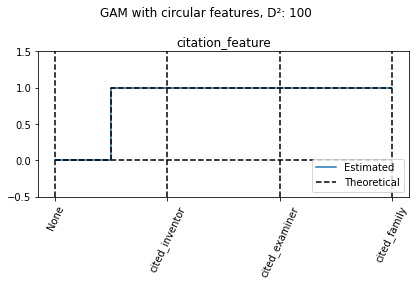

In [12]:
gam = circularity_candidate[1]
title = f"GAM with circular features, D²: {round(score(gam, data[circular_features].to_numpy(), data[target].to_numpy())*100)}"
plot_gam_terms(config, gam, circular_features, decision_funct=decision_function, title=title)

Plot GAM on full feature set: Nicely visible is the **Nullification** of the features that do not define the target labeling function.

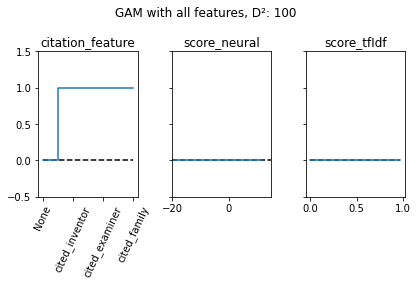

In [13]:
title = f"GAM with all features, D²: {round(score(full_gam, data[features].to_numpy(), data[target].to_numpy())*100)}"
plot_gam_terms(config, full_gam, features, title=title)

Plot GAM on non-circular features for comparison: If circular features are not given, the other features have a reasonable impact on the prediction.
But the fit of the model is not optimal. 

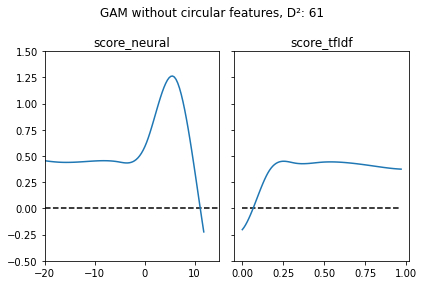

In [14]:
non_circular_gam = [gam[1] for gam in sorted_result_gams if gam[0] == nullified_features][0]
title = f"GAM without circular features, D²: {round(score(non_circular_gam, data[nullified_features].to_numpy(), data[target].to_numpy())*100)}"

plot_gam_terms(config, non_circular_gam, nullified_features, title=title)
